## Stray light analysis (part 2)

## Stray light analysis (part 2)

This is part 2 of the stray light analysis, which is covered on MRD level by requirement MRD-L1B-0170.
<div>
<img src="MRD-ESRA-Carbon.png" width="800"/>
</div>

Stray light induced errors $\delta y_{sl}$ is one contribution to ESRA. 

Using the analysis of the first part, we assume a binary contrast scene between aan alebdo $A=0.15$ and $A=0.45$ with $\Delta A = 0.3$. This is important for a proper flow-down to SRD. For a binary contrast scene includes $L_\mathrm{ref}$ as the drak scene.
+ We simulate the L1A product accounting for spectrometer stray light and ignoring stray light. On the level of detector images, the stray light effect is illustrated. CKD stray light kernel is illustrated.
+ Next, we simulate L1B data from stray light contaminated with and without stray light correction. 
+ We derive the induced L2 error as a function of ACT index.
+ Finally, we use the gain vectors to estimate L2 induced stray light errors to illustrate validity of the stray light contribution to the ESRA requirement. 

#### 1. Set working enviroment

In [41]:
import sys
sys.path.append("/home/jochen/pythonenvs/tangoendtoend/lib64/python3.11/site-packages")
import os
import yaml
import numpy as np
from netCDF4 import Dataset
from copy import deepcopy
import matplotlib.pyplot as plt

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp7_straylight/")

### 2. Import teds modules

In [42]:
from teds.gm.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import run_instrument_model
from teds.l1al1b import run_l1al1b
from teds.l1l2.l1bl2 import level1b_to_level2_processor
from teds.siml1b import simplified_instrument_model_and_l1b_processor
from teds.pam import pam_co2

### 3. Set overall path and flags to swich on/off cells

In [43]:
path  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/'

proc_gm     = True
proc_sgmgeo = True
proc_sgmrad = True
proc_im     = True;  pam_im = True
proc_l1al1b = True;  pam_l1b = True
proc_l1bl2  = True;  pam_l2 = True


Cell 4-6 set up the scene and are illustrated regarding their functionality in other notebooks.   

### 4. GM

In [44]:
if(proc_gm):
    #configureation file
    #In this case, the gm does not include solar and viewing geometry. It is easier to define them with the notebook
    gm_config= yaml.safe_load(open('./settings/gm_config_7.1.yaml'))
    #we use the nact dimension to simulate scenes with different scaling factors s and the geometry of Lref
    nact = 500 
    gm_config['scene_spec'] = {}
    gm_config['scene_spec']['sza'] = np.zeros(nact) + 70.
    gm_config['scene_spec']['saa'] = np.zeros(nact) 
    gm_config['scene_spec']['vza'] = np.zeros(nact) 
    gm_config['scene_spec']['vaa'] = np.zeros(nact) 

    geometry_module(gm_config)


[15:00:08] Generating detector image timestamps
[15:00:08] Generating geometry for 500 across track locations


#########################
# Tango geometry module #
#########################
Version                 : 0.0.1
Commit hash             : 7d395538
Date and timezone       : 2025 February 11 Tue
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic


###########
# Success #
###########


#### 5. SGM-GEO

In [45]:
if(proc_sgmgeo):

    nact = 500
    nact2 = np.int16(nact/2)
    albedo = np.ones(nact)*0.15
    albedo[nact2:nact] = np.ones(nact2)*0.45
    sgmgeo_config= yaml.safe_load(open('./settings/sgmgeo_config_7.1.yaml'))
    sgmgeo_config['scene_spec']={}
    sgmgeo_config['scene_spec']['albedo'] = albedo
    geoscene_generation(sgmgeo_config)


###########
# Success #
###########


/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/teds/gm/vincenty.py:62: RuntimeWarning: invalid value encountered in divide
  cU1 * cU2 * slam / sin_sigma)


#### 6. SGM-RAD

In [46]:
if(proc_sgmrad):
    sgmrad_config= yaml.safe_load(open('./settings/sgmrad_config_7.1.yaml'))
    Carbon_radiation_scene_generation(sgmrad_config)

Radiative tranfer simulation...


100%|██████████| 1/1 [00:18<00:00, 18.44s/it]



###########
# Success #
###########


### 7. Stray light CKD
Plot stray light kernel in CKD file coming from dedicated instrument simulations (TNO) and included in the CKD set. 

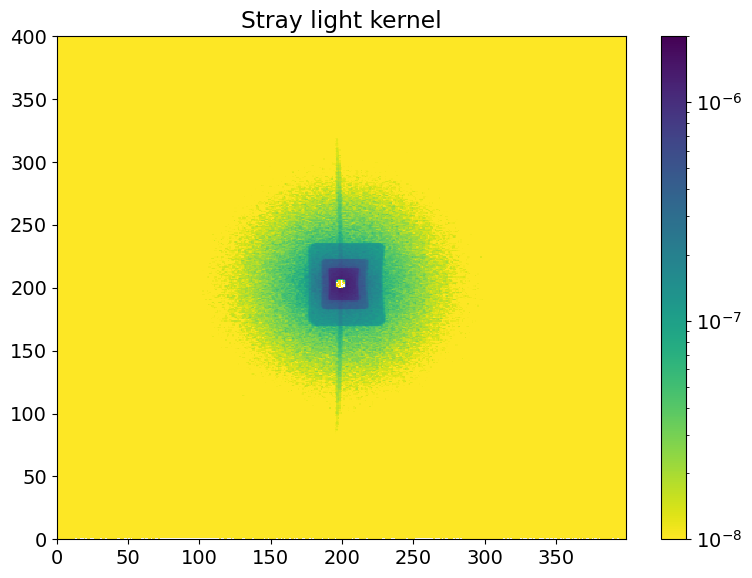

In [47]:
from scipy.fft import ifft2
from matplotlib import colors

im_config= yaml.safe_load(open('./settings/im_config_7.1.yaml'))
ckd = Dataset(im_config['io']['ckd'])
kernel_n_rows = ckd['stray/kernel_rows'][0]
kernel_n_cols = ckd['stray/kernel_cols'][0]

#stray light is stored as Fourier Transformed in the ckd file 
kernel_fft_sizes = ckd['stray/kernel_fft_sizes']
kernels_fft = ckd['stray/kernels_fft']
global_beg = 2 * sum(kernel_fft_sizes[0:0])
global_end = global_beg + 2 * kernel_fft_sizes[0]
kernel_fft = kernels_fft[global_beg:global_end]
fft_re_packed = np.reshape(kernel_fft[::2],
                           (kernel_n_rows // 2 + 1, kernel_n_cols))
fft_im_packed = np.reshape(kernel_fft[1::2], fft_re_packed.shape)
fft_packed = fft_re_packed + 1j * fft_im_packed
fft_full = np.zeros((kernel_n_rows, kernel_n_cols), dtype='complex128')

mid = kernel_n_rows // 2 + 1
fft_full[:mid, :] = fft_packed
fft_full[mid::, 0] = np.conjugate(fft_packed[mid - 2:0:-1, 0])
fft_full[mid::, 1:] = np.conjugate(
    fft_packed[mid - 2:0:-1, kernel_n_cols:0:-1])

kernel = ifft2(fft_full)

midpoints = (kernel_n_rows // 2, kernel_n_cols // 2)
fft_full = np.roll(fft_full, midpoints, (0, 1))
kernel = np.roll(kernel, midpoints, (0, 1))

# Crop to a smaller size
kernel = kernel[311:711, 376:775]

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 6))
psm = ax.pcolormesh(kernel.real, norm=colors.LogNorm(1e-8, 2e-6), cmap='viridis_r',)

cb = fig.colorbar(psm, ax=ax)
ax.set_title('Stray light kernel')

plt.tight_layout()
plt.show()

### 8. Instrument model 

Run the instrument model for each scaled scenes using a seperate call 

In [34]:
if(proc_im):
    im_config= yaml.safe_load(open('./settings/im_config_7.1.yaml'))
    im_config['io']['l1a']='/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1a/Tango_Carbon_l1a_exp7.1_with_strayl.nc'
    im_config['stray']['enabled']=True
    run_instrument_model(im_config)

    im_config= yaml.safe_load(open('./settings/im_config_7.1.yaml'))
    im_config['io']['l1a']='/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1a/Tango_Carbon_l1a_exp7.1_without_strayl.nc'
    im_config['stray']['enabled']=False
    run_instrument_model(im_config)

[14:55:15] Processing from SGM to l1a
[14:55:16] Reading input data
[14:55:16] ISRF convolution


##########################
# Tango instrument model #
##########################
Version                 : 0.0.1
Commit hash             : 7d395538
Date and timezone       : 2025 February 11 Tue
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic

##############################
# Reading CKD and input data #
##############################

#################
# Forward model #
#################


100%|██████████| 1/1 [00:02<00:00,  2.11s/ ALT]
[14:55:18] Radiometric
100%|██████████| 1/1 [00:00<00:00, 1596.01it/s]
[14:55:18] Detector mapping
100%|██████████| 1/1 [00:02<00:00,  2.75s/it]
[14:55:21] Stray light
100%|██████████| 1/1 [00:00<00:00, 12.92it/s]
[14:55:21] PRNU
[14:55:21] Nonlinearity
[14:55:21] Dark signal
[14:55:21] Dark offset
[14:55:21] Analog-to-digital conversion
[14:55:21] Writing output data
[14:55:21] Processing from SGM to l1a
[14:55:21] Reading input data
[14:55:21] ISRF convolution



###########
# Success #
###########
##########################
# Tango instrument model #
##########################
Version                 : 0.0.1
Commit hash             : 7d395538
Date and timezone       : 2025 February 11 Tue
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic

##############################
# Reading CKD and input data #
##############################

#################
# Forward model #
#################


100%|██████████| 1/1 [00:02<00:00,  2.33s/ ALT]
[14:55:23] Radiometric
100%|██████████| 1/1 [00:00<00:00, 772.43it/s]
[14:55:23] Detector mapping
100%|██████████| 1/1 [00:02<00:00,  2.94s/it]
[14:55:26] PRNU
[14:55:26] Nonlinearity
[14:55:26] Dark signal
[14:55:26] Dark offset
[14:55:26] Analog-to-digital conversion
[14:55:27] Writing output data



###########
# Success #
###########


Visualize L1A stray light error 

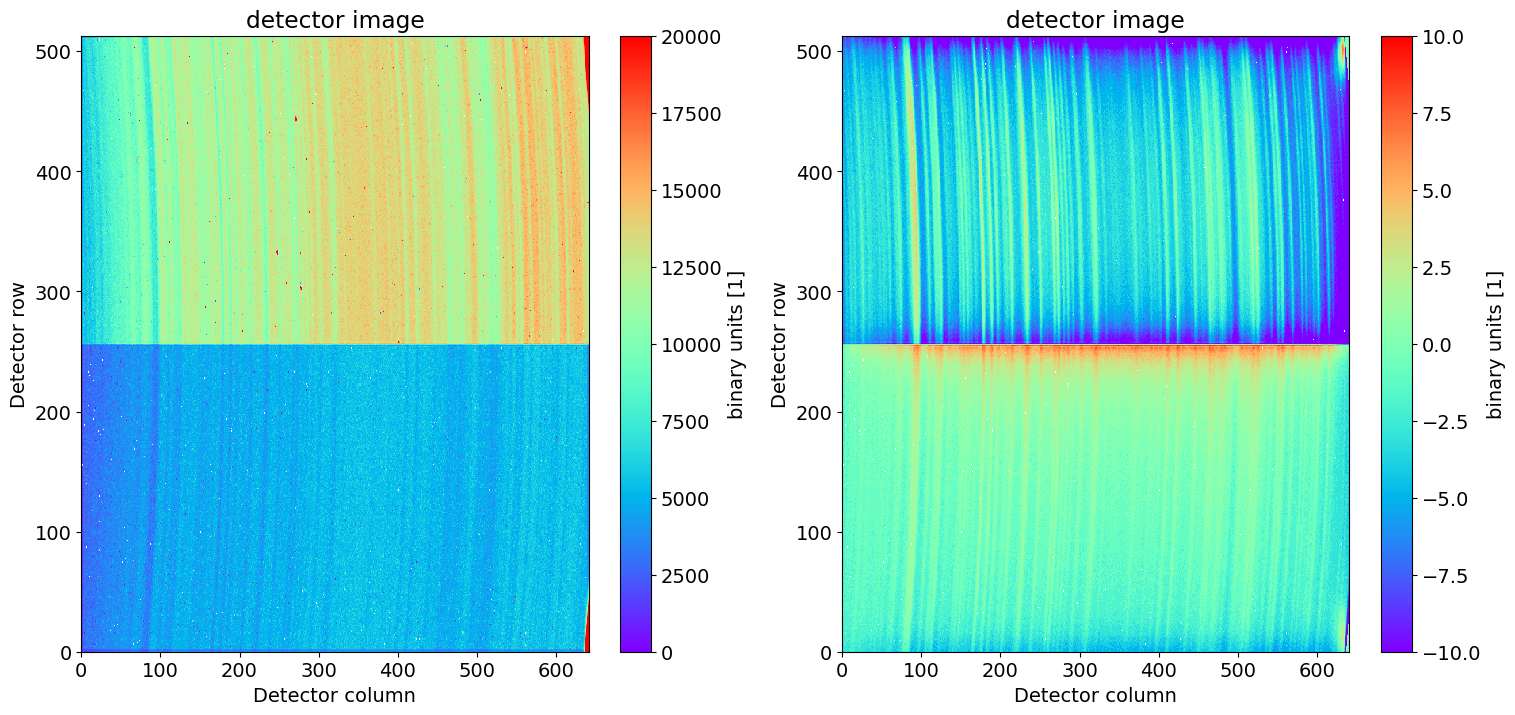

In [35]:
if(pam_im):

    level1a_with_strayl = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1a/Tango_Carbon_l1a_exp7.1_with_strayl.nc')
    level1a_without_strayl = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1a/Tango_Carbon_l1a_exp7.1_without_strayl.nc')

    # detector dimensions
    plt.rcParams['font.size'] = 14
    title = 'detector image'
    n_bins = level1a_with_strayl.dimensions['bin'].size
    n_cols = 640
    n_rows = np.int16(n_bins/n_cols)
    
    # Read data
    image_no = 0
    image_ws = level1a_with_strayl['science_data']['detector_image'][image_no, :]
    image_ws = image_ws.reshape(n_rows, n_cols)
    image_wos = level1a_without_strayl['science_data']['detector_image'][image_no, :]
    image_wos = image_wos.reshape(n_rows, n_cols)
    
    level1a_with_strayl.close()
    level1a_without_strayl.close()

    data_max = 20000
    x_values = np.linspace(0, n_cols+1, n_cols+1)
    y_values = np.linspace(0, n_rows+1, n_rows+1)

    # Set up plotting

    fig, axs  = plt.subplots(
    1,
    2,
    figsize=(18, 8),
    dpi=100,)
   
    ax0 = axs[0]
    ax0.set_xlabel('Detector column')
    ax0.set_ylabel('Detector row')
    ax0.set_title(title)

    psm = ax0.pcolormesh(
        x_values,
        y_values,
        image_ws,
        cmap='rainbow',
        vmax=data_max)

    cb = fig.colorbar(psm, ax=ax0)
    cb.set_label('binary units [1]')

    ax1 = axs[1]
    ax1.set_xlabel('Detector column')
    ax1.set_ylabel('Detector row')
    ax1.set_title(title)

    psm = ax1.pcolormesh(
        x_values,
        y_values,
        image_ws-image_wos,
        cmap='rainbow',
        vmin=-10,
        vmax=10,)

    cb = fig.colorbar(psm, ax=ax1)
    cb.set_label('binary units [1]')



### 9. L1B processing
We use the L1A product simulated with stray light and extract two L1B products, one with stray light correction and the other without stray light correction. 

In [36]:
if(proc_l1al1b):
   l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config_7.1.yaml'))
   l1al1b_config['stray']['van_cittert_steps']= 4
   l1al1b_config['io']['l1a'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1a/Tango_Carbon_l1a_exp7.1_with_strayl.nc'
   l1al1b_config['io']['l1b'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1b/Tango_Carbon_l1b_exp7.1_with strayl_corr.nc'
   run_l1al1b(l1al1b_config)

   l1al1b_config['stray']['van_cittert_steps']= 0
   l1al1b_config['io']['l1a'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1a/Tango_Carbon_l1a_exp7.1_with_strayl.nc'
   l1al1b_config['io']['l1b'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1b/Tango_Carbon_l1b_exp7.1_without strayl_corr.nc'
   run_l1al1b(l1al1b_config)

[14:55:28] Processing from L1A to L1B
[14:55:28] Reading input data


#######################
# Tango L1B processor #
#######################
Version                 : 0.0.1
Commit hash             : 7d395538
Date and timezone       : 2025 February 11 Tue
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic

##############################
# Reading CKD and input data #
##############################


[14:55:30] Coadding and binning
[14:55:30] Dark offset
[14:55:30] Noise
[14:55:30] Dark current
[14:55:30] Nonlinearity



#############
# Retrieval #
#############


100%|██████████| 1/1 [00:00<00:00, 22.84it/s]
[14:55:30] PRNU
100%|██████████| 1/1 [00:00<00:00, 38.08it/s]
[14:55:30] Smoothing over bad values
100%|██████████| 1/1 [00:00<00:00,  5.30it/s]
[14:55:31] Stray light
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
[14:55:31] Mapping from detector
100%|██████████| 1/1 [00:07<00:00,  7.54s/it]
[14:55:39] Interpolating from intermediate to main CKD wavelength grids
[14:55:39] Radiometric
[14:55:39] Writing output data
[14:55:39] Processing from L1A to L1B
[14:55:39] Reading input data



###########
# Success #
###########
#######################
# Tango L1B processor #
#######################
Version                 : 0.0.1
Commit hash             : 7d395538
Date and timezone       : 2025 February 11 Tue
Contacts                : raullaasner@gmail.com
                          bitbucket.org/sron_earth/teds/issues (request permission)
Host system             : Linux 6.8.0-52-generic

##############################
# Reading CKD and input data #
##############################


[14:55:41] Coadding and binning
[14:55:41] Dark offset
[14:55:41] Noise
[14:55:41] Dark current
[14:55:41] Nonlinearity



#############
# Retrieval #
#############


100%|██████████| 1/1 [00:00<00:00, 22.72it/s]
[14:55:41] PRNU
100%|██████████| 1/1 [00:00<00:00, 47.87it/s]
[14:55:41] Smoothing over bad values
100%|██████████| 1/1 [00:00<00:00,  5.96it/s]
[14:55:41] Mapping from detector
100%|██████████| 1/1 [00:07<00:00,  7.81s/it]
[14:55:49] Interpolating from intermediate to main CKD wavelength grids
[14:55:49] Radiometric
[14:55:49] Writing output data



###########
# Success #
###########


Data analysis level 1B

Plot extracted L1B radiances as a function of ACT position and spectral index and the error when stray light is not corrected in the L1B processor

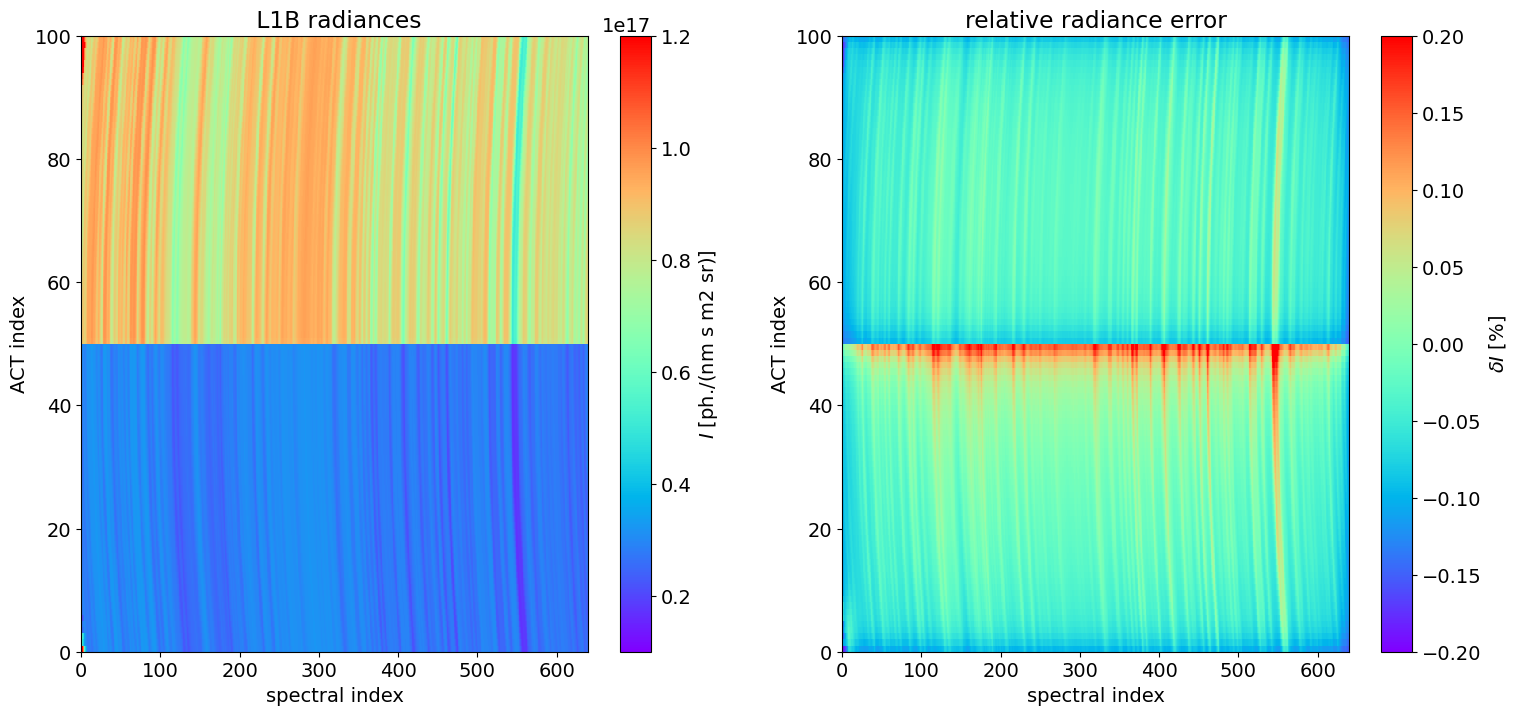

In [37]:
if(pam_l1b):

    l1b_w_strayl_corr = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1b/Tango_Carbon_l1b_exp7.1_with strayl_corr.nc')
    l1b_wo_strayl_corr = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1b/Tango_Carbon_l1b_exp7.1_without strayl_corr.nc')    
    radiance_w_strayl_corr = l1b_w_strayl_corr['observation_data/radiance'][0,:,:]
    radiance_wo_strayl_corr = l1b_wo_strayl_corr['observation_data/radiance'][0,:,:]
    l1b_w_strayl_corr.close()
    l1b_wo_strayl_corr.close()

    plt.rcParams.update({'font.size': 14,})

    fig, axs  = plt.subplots(
        1,
        2,
        figsize=(18, 8),
        dpi=100,)
   
    ax0 = axs[0]
    ax0.set_xlabel('spectral index')
    ax0.set_ylabel('ACT index')
    ax0.set_title(' L1B radiances')

    psm = ax0.pcolormesh(
        radiance_w_strayl_corr,
        cmap='rainbow',
        vmax= 1.2E17,
        vmin= 1.E16)

    cb = fig.colorbar(psm, ax=ax0)
    cb.set_label('$I$ [ph./(nm s m2 sr)]')

    rel_rad_error = (radiance_wo_strayl_corr - radiance_w_strayl_corr)/radiance_w_strayl_corr*100.

    ax1 = axs[1]
    ax1.set_xlabel('spectral index')
    ax1.set_ylabel('ACT index')
    ax1.set_title('relative radiance error')

    psm = ax1.pcolormesh(
        rel_rad_error,
        cmap='rainbow',
        vmin=-0.2,
        vmax=0.2,)

    cb = fig.colorbar(psm, ax=ax1)
    cb.set_label('$\delta I$ [%]')

### 10. Level 2

Extract the L2 product from the L1B with and without stray light correction

In [38]:
if(proc_l1bl2):
   l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config_7.1.yaml'))
   l1bl2_config['io_files']['input_l1b'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1b/Tango_Carbon_l1b_exp7.1_with strayl_corr.nc'
   l1bl2_config['io_files']['output_l2'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_with strayl_corr.nc'
   l1bl2_config['io_files']['output_l2_diag'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_diag_exp7.1_with strayl_corr.nc'
   level1b_to_level2_processor(l1bl2_config)

   l1bl2_config['io_files']['input_l1b'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level1b/Tango_Carbon_l1b_exp7.1_without strayl_corr.nc'
   l1bl2_config['io_files']['output_l2'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_without strayl_corr.nc'
   l1bl2_config['io_files']['output_l2_diag'] = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_diag_exp7.1_without strayl_corr.nc'
   level1b_to_level2_processor(l1bl2_config)

level 1B to 2 proessor ...


100%|██████████| 1/1 [02:33<00:00, 153.47s/it]


/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_with strayl_corr.nc
diag_output
=> l1bl2 finished successfully
level 1B to 2 proessor ...


100%|██████████| 1/1 [01:41<00:00, 101.51s/it]

/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_without strayl_corr.nc
diag_output
=> l1bl2 finished successfully


### 11. L2 Data Analysis

#### 11.1 Overview on L2 

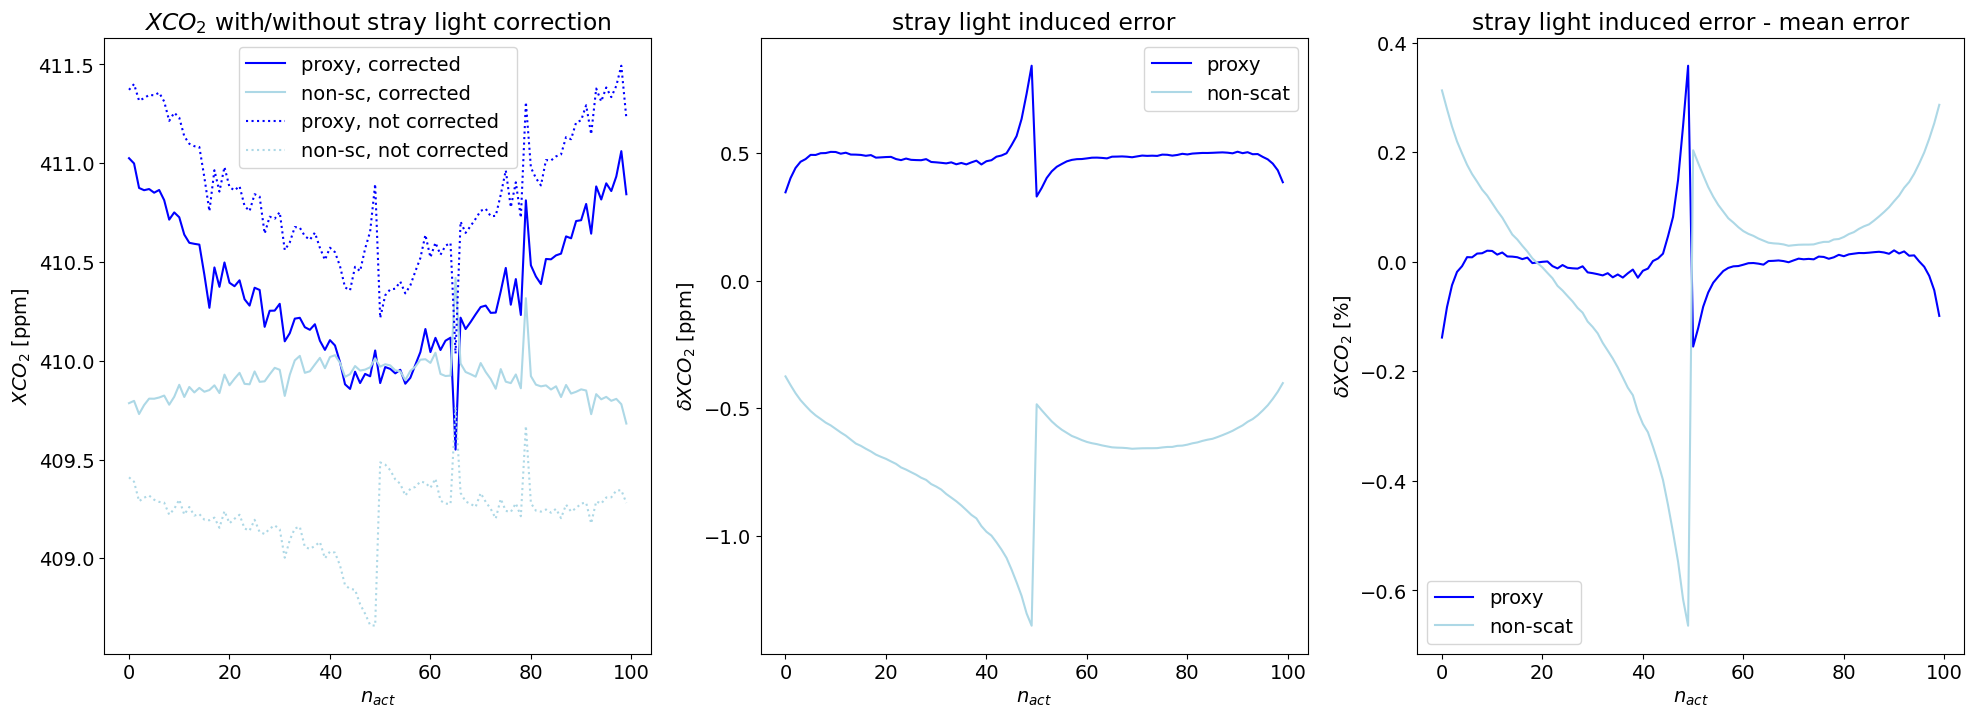

In [39]:
if(pam_l2):
    filen  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_with strayl_corr.nc'
    l2_data  = Dataset(filen)
    l2_w_sc = {}
    l2_w_sc['prec_xco2_proxy'] = np.array((l2_data['precision XCO2 proxy'][:]).flatten())
    l2_w_sc['xco2_proxy'] = np.array((l2_data['XCO2 proxy'][:]).flatten())    
    l2_w_sc['xco2_ns'] = np.array((l2_data['non_scattering_retrieval']['XCO2'][:]).flatten())
    l2_data.close()

    filen  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_without strayl_corr.nc'
    l2_data  = Dataset(filen)
    l2_wo_sc = {}
    l2_wo_sc['prec_xco2_proxy'] = np.array((l2_data['precision XCO2 proxy'][:]).flatten())
    l2_wo_sc['xco2_proxy'] = np.array((l2_data['XCO2 proxy'][:]).flatten())    
    l2_wo_sc['xco2_ns'] = np.array((l2_data['non_scattering_retrieval']['XCO2'][:]).flatten())
    l2_data.close()

    fig, axs  = plt.subplots(
        1,
        3,
        figsize=(24, 8),
        dpi=100,)
   
    ax0 = axs[0]
    ax0.plot(l2_w_sc['xco2_proxy'], color = 'blue', label = 'proxy, corrected')
    ax0.plot(l2_w_sc['xco2_ns'], color = 'lightblue', label = 'non-sc, corrected')
    ax0.plot(l2_wo_sc['xco2_proxy'], color = 'blue', linestyle='dotted', label = 'proxy, not corrected')
    ax0.plot(l2_wo_sc['xco2_ns'], color = 'lightblue', linestyle='dotted', label = 'non-sc, not corrected')
 
    ax0.set_xlabel('$n_{act}$')
    ax0.set_ylabel('$XCO_2$ [ppm]')
    ax0.set_title('$XCO_2$ with/without stray light correction')
    ax0.legend()

    ax1 = axs[1]
            
    error_proxy = (l2_wo_sc['xco2_proxy'] - l2_w_sc['xco2_proxy'])
    error_ns = (l2_wo_sc['xco2_ns'] - l2_w_sc['xco2_ns'])
    ax1.plot(error_proxy, color = 'blue', label = 'proxy')
    ax1.plot(error_ns, color = 'lightblue', label = 'non-scat')
    ax1.legend()
 
    ax1.set_xlabel('$n_{act}$')
    ax1.set_ylabel('$\delta XCO_2$ [ppm]')
    ax1.set_title('stray light induced error')

    ax2 = axs[2]
            
    error_proxy_rel = error_proxy-np.mean(error_proxy)
    error_ns_rel = error_ns-np.mean(error_ns)
    ax2.plot(error_proxy_rel, color = 'blue', label = 'proxy')
    ax2.plot(error_ns_rel, color = 'lightblue', label = 'non-scat')
    ax2.legend()
 
    ax2.set_xlabel('$n_{act}$')
    ax2.set_ylabel('$\delta XCO_2$ [%]')
    ax2.set_title('stray light induced error - mean error')

#### Interpretation
Truth XCO2 = 410 ppm
* Left: The non-scattering XCO2 shows a significant data discontinuity at the albedo transition ($n_{act}=50$). This is well corrected by the stray light correction. The V-shape and the scatter on the proxy data come from the keystone induced error. Ignore this for our stray light analysis. The data discontinuity is clearly reduced in the proxy product.
* Middle: The stray light induced error. At the transition zone the errors are reduced in the proxy product. Still an overall offset is present of 0.5 ppm and a feature of 0.4 ppm. 
* Right: For TANGO flux inversion only the enhamcement of XCO2 with respect to the background matters. Therefore, we substract the mean error in this diagram. It confirms the finding from the the middle planel that stray light can introduce a error feature of $\le$ 0.4 ppm (0.1 %). 

A stray light correction in the L1B algorithm can reduce the error. The quality of such a correction depends on many parameters that are not considered here. However, expereince with other mission show that a correction by a factor 4 is feasible leading to L2 stray light induced errors of $\le 0.15$ ppm (0.025 %).

#### 11.2 Linear error analysis using gain vectors (ESRA requirement)

Text(0.5, 1.0, 'Errors of linear error propagation')

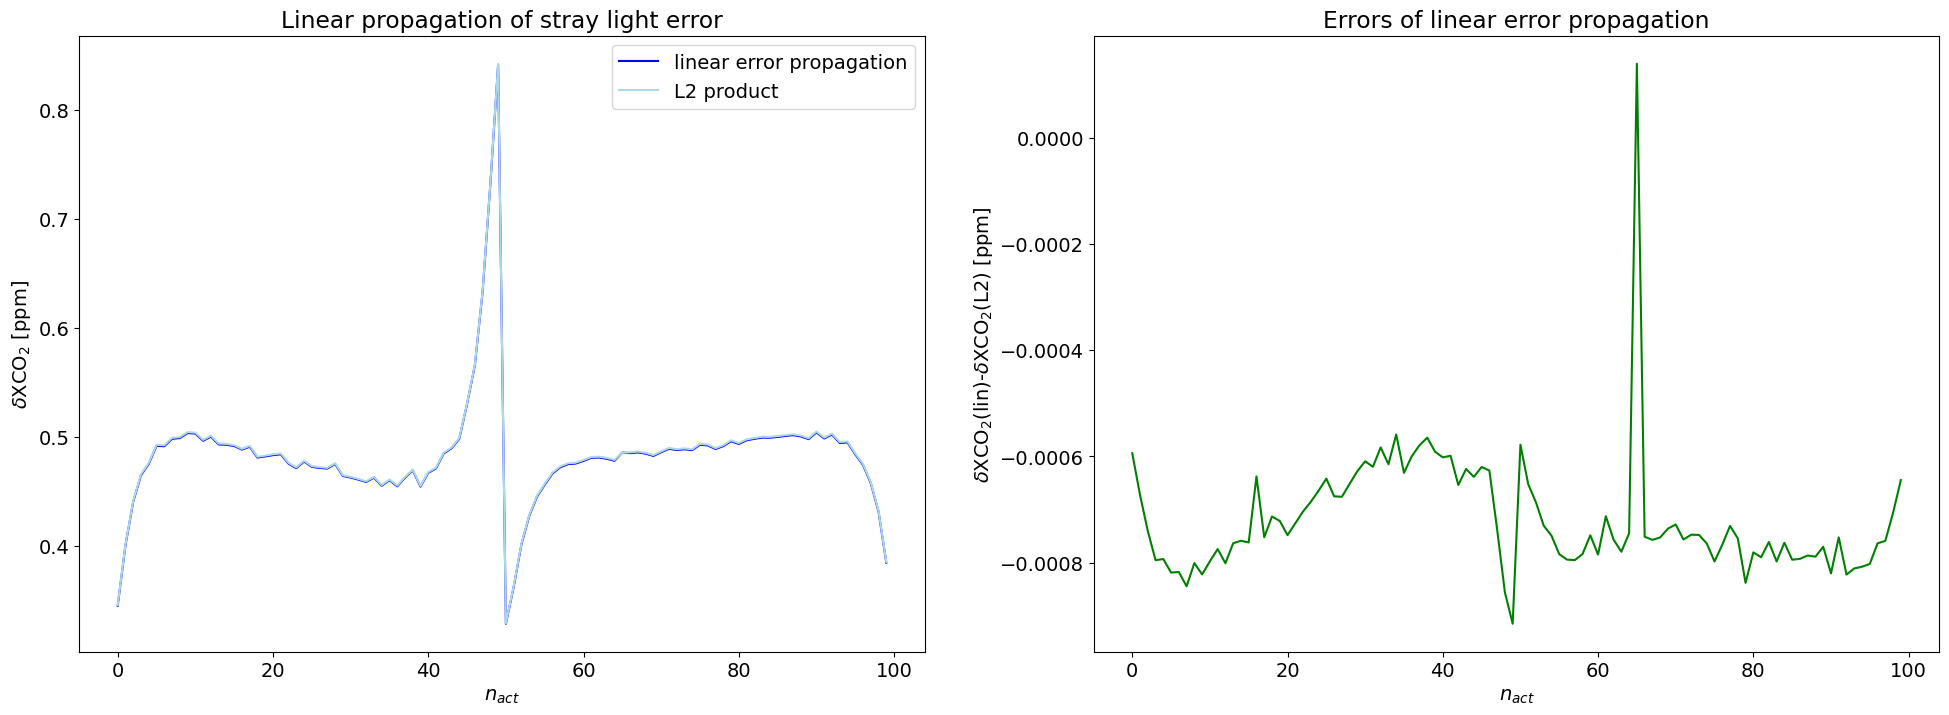

In [40]:
# Determine the proxy gain vectors for the reference case with stray light correction
# It is important to take the radiances from the diag file as this covers the spectral 
# range used in the L2 processor and so is harmonized with the defintion of the gain vectors.

filel2_diag = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_diag_exp7.1_with strayl_corr.nc'
diag= Dataset(filel2_diag, mode='r')
gain_ch4_ns    = diag['gain CH4'][:]
gain_co2_ns    = diag['gain CO2'][:]
rad_with_slc   = diag['measurement'][:]
wavelength     = diag['wavelength'][:]
diag.close()

filel2_diag = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_diag_exp7.1_without strayl_corr.nc'
diag= Dataset(filel2_diag, mode='r')
rad_without_slc = diag['measurement'][:]
diag.close()

filen  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_with strayl_corr.nc'
l2_data  = Dataset(filen)   
xco2_ns = np.array((l2_data['non_scattering_retrieval']['XCO2'][:]))
xch4_ns = np.array((l2_data['non_scattering_retrieval']['XCH4'][:]))
xco2_proxy = np.array((l2_data['XCO2 proxy'][:]))
xch4_proxy = np.array((l2_data['XCH4 proxy'][:]))
l2_data.close()

nalt, nact, nwave = gain_co2_ns.shape
gain_co2_proxy  = np.zeros([nact,nwave])
gain_ch4_proxy  = np.zeros([nact,nwave])

for iact in range(nact):
    gain_co2_proxy[iact,:] = (gain_co2_ns[0,iact,:]/xco2_ns[0,iact] - gain_ch4_ns[0,iact,:]/xch4_ns[0,iact])*xco2_proxy[0,iact]
    gain_ch4_proxy[iact,:] = (gain_ch4_ns[0,iact,:]/xch4_ns[0,iact] - gain_co2_ns[0,iact,:]/xco2_ns[0,iact])*xch4_proxy[0,iact]

Lin_delta_XCO2 = np.zeros(nact)

for iact in range(nact):
    #calculate the radiance error because of ingoring the stray light correction
    deltarad = (rad_without_slc[0,iact,:] - rad_with_slc[0,iact,:])
    #apply the proxy gain
    Lin_delta_XCO2[iact]  = np.dot(gain_co2_proxy[iact,:],deltarad)

#As reference, read the L2 product from file (see also cell above)
filen  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_with strayl_corr.nc'
l2_data  = Dataset(filen)
L2_XCO2_proxy_with_slc = np.array((l2_data['XCO2 proxy'][:]))    
l2_data.close()

filen  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/level2/Tango_Carbon_l2_exp7.1_without strayl_corr.nc'
l2_data  = Dataset(filen)
L2_XCO2_proxy_without_slc = np.array((l2_data['XCO2 proxy'][:]))    
l2_data.close()
L2_delta_XCO2 = L2_XCO2_proxy_without_slc[0,:]-L2_XCO2_proxy_with_slc[0,:]

#plotting of the stray light error in the L2 product (see also previous cell) amd the predicted error using linear error analysis (gain, ESRA)

fig, axs  = plt.subplots(
        1,
        2,
        figsize=(24, 8),
        dpi=100,)
   
ax0 = axs[0]
ax0.plot(Lin_delta_XCO2, color = 'blue', label = 'linear error propagation')
ax0.plot(L2_delta_XCO2, color = 'lightblue', label = 'L2 product')

ax0.set_xlabel('$n_{act}$')
ax0.set_ylabel('$\delta \mathrm{XCO_2}$ [ppm]')
ax0.set_title('Linear propagation of stray light error')
ax0.legend()

ax1 = axs[1]
ax1.plot(Lin_delta_XCO2-L2_delta_XCO2, color = 'green', )
ax1.set_xlabel('$n_{act}$')
ax1.set_ylabel('$\delta \mathrm{XCO_2}$(lin)-$\delta \mathrm{XCO_2}$(L2) [ppm]')
ax1.set_title('Errors of linear error propagation')

Interpretation:

Linear error propagation works very well for stray light induced L1B error.

## Overall conclusion:

We presented error propagation of 
+ CKD $\to$ L0/L1A stray light performance
+ L0/L1A stray light performance $\to$ L1B performance 
+ L1B stray light performance $\to$ L2 performance 
+ Validity of linear error propagation
+ Working interface of the E2ES with CKD modelling

Moreover, we shows that for a transition  $A=0.15$ to $A=0.45$ the L2 error is about 0.4 ppm in the proxy product, if stray light is not corrected in the L1B product. Using well estabished stray light algorithms a correction by a factor 4 is reasonable leading to a small error contribution of Carbon spectrometer stray light in the order of 0.1 ppm. 
